In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import gc
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical


2024-07-22 08:41:55.767527: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-22 08:41:55.767675: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-22 08:41:55.925484: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Read Dataset
base_path = '/kaggle/input/grayscale-dfdc'
sub_path = '/kaggle/working'

video_data = []
audio_data = []
labels = []
# REAL - 2 3, Fake 1 2 
for folder in os.listdir(base_path):
    temp_path = f"{base_path}/{folder}{sub_path}"
    if (folder == 'REAL_GS_00' or folder == 'REAL_GS_01' or folder == 'FAKE_GS_00'):
        continue
    for label in os.listdir(temp_path):

        for video_audio_folder in os.listdir(f"{temp_path}/{label}"):
            video_data.append(np.load(f"{temp_path}/{label}/{video_audio_folder}/video.npy"))
            audio_data.append(np.load(f"{temp_path}/{label}/{video_audio_folder}/audio.npy"))
            labels.append(label)


In [3]:
video_sequence = [len(video) for video in video_data]

audio_sequence = [audio.shape[1] for audio in audio_data]


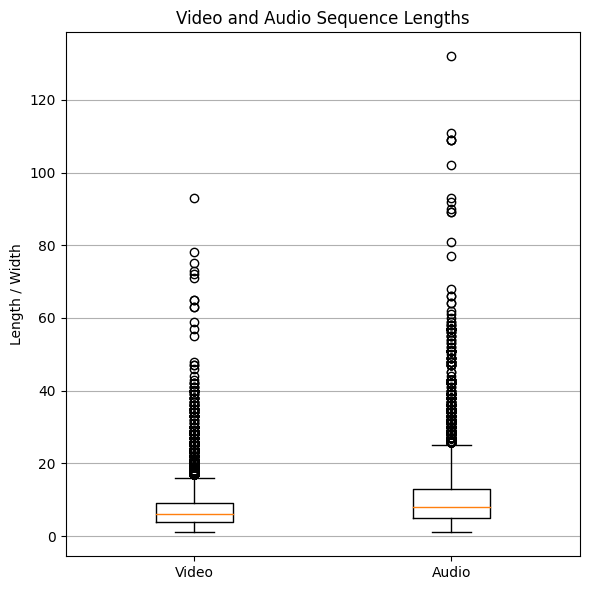

In [4]:
# Create a figure for both boxplots
plt.figure(figsize=(6, 6))

# Plot boxplot for video sequence
plt.boxplot(video_sequence, positions=[1], widths=0.3)

# Plot boxplot for audio sequence
plt.boxplot(audio_sequence, positions=[2], widths=0.3)

# Set labels and title
plt.xticks([1, 2], ['Video', 'Audio'])
plt.ylabel('Length / Width')
plt.title('Video and Audio Sequence Lengths')

# Display plot
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [5]:
max_sequence_audio = 25

# Remove outlier based on audio sequence because it represent the actual number of frame
final_video_data = []
final_audio_data = []
final_labels = []

count = 0
for index, length in enumerate(audio_sequence):
    if (length <= max_sequence_audio):
        final_video_data.append(video_data[index])
        final_audio_data.append(audio_data[index])
        final_labels.append(labels[index])
        count = count + 1

    
print(f"Total outlier: {len(audio_sequence) - count}/{len(audio_sequence)}")
print(f"Final Dataset Size: {len(final_audio_data)}")

Total outlier: 578/16916
Final Dataset Size: 16338


In [6]:
# Initialize padded video data
final_video_data = pad_sequences(final_video_data, dtype='float32', padding='post', truncating='post', value=0.0 )

# Add a channel dimension
final_video_data = np.expand_dims(final_video_data, axis=-1)


## Audio Processing for CLL (LSTM)

In [7]:
# Find global min and max of log mel spectrogram for normalziation purpose
global_min = min(np.min(spectrogram) for spectrogram in final_audio_data)
global_max = max(np.max(spectrogram) for spectrogram in final_audio_data)

for i, audio in enumerate(final_audio_data):
    # transpose audio data
    transpose_audio = audio.transpose()
    
    # Normalize the log-mel spectrogram
    normalized_audio = (transpose_audio - global_min) / (global_max - global_min)
    
    final_audio_data[i] = normalized_audio
    

# add paddding to audio data
final_audio_data = pad_sequences(final_audio_data, dtype='float32', padding='post', truncating='post', value=0.0 )

In [8]:
global_min

-80.0

In [9]:
global_max

3.8146973e-06

## Audio Processing for CLC (CNN)

In [10]:
# Resize log-mel spectrogram
for i, audio in enumerate(final_audio_data):
    height = 128
    width = 25
    
    # Select interpolation_set
    if audio.shape[1] < width or audio.shape[0] < height:
        interpolation_set = cv2.INTER_CUBIC  # For upsampling
    else:
        interpolation_set = cv2.INTER_AREA  # For downsampling
        
    final_audio_data[i] = cv2.resize(audio, (width, height), interpolation=interpolation_set)
    
    
# Find global min and max of log mel spectrogram for normalziation purpose
global_min = min(np.min(spectrogram) for spectrogram in final_audio_data)
global_max = max(np.max(spectrogram) for spectrogram in final_audio_data)

# Normalize the log-mel spectrogram
for i, audio in enumerate(final_audio_data):
    # min_max normalization
    normalized_audio = (audio - global_min) / (global_max - global_min)
    
    # Add channel dimension
    np.expand_dims(normalized_audio, axis=-1) 
    
    final_audio_data[i] = normalized_audio
    

In [13]:
global_min

-83.96437

In [14]:
global_max

2.1400836

## Prepare Train and Test dataset

In [10]:
final_video_data = np.array(final_video_data)
final_audio_data = np.array(final_audio_data)
encoded_labels = LabelEncoder().fit_transform(final_labels)


In [ ]:
Video_train, Video_test, Audio_train, Audio_test, y_train, y_test = train_test_split(
    final_video_data, final_audio_data, encoded_labels, random_state=50, test_size=0.25, shuffle=True
)

In [ ]:
# file_name = 'training_data_CLL.npz' # Choose file name based on audio processing type
file_name = 'training_data_CLC.npz'

np.savez_compressed(file_name, 
                   Video_train=Video_train, 
                   Video_test=Video_test, 
                   Audio_train=Audio_train,
                   Audio_test=Audio_test, 
                   y_train=y_train, 
                   y_test=y_test)

In [11]:
# Save unsplited data for cross_validation
np.savez_compressed('unsplited_data_CLL.npz', 
                   final_video_data=final_video_data, 
                   final_audio_data=final_audio_data, 
                   encoded_labels=encoded_labels)